In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import tree
#import autokeras as ak
from sklearn.metrics import mean_squared_error
from math import sqrt
#from tensorflow.keras.utils import plot_model
#import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [5]:
data = pd.read_csv("allList.csv")

In [ ]:
#‪C:\Users\fprkwk\Desktop\unnormal.csv

In [ ]:
data

In [6]:
"""
이 함수는 로트 구분을 위한 함수임
df_list = 정상 로트별로 데이터 프레임을 만든것
df_list2 = 비정상 로트별로 데이터 프레임을 만든것
df_list의 예시 구조는 
[ df[1번 로트의 69개의 센서 값],
  df[2번 로트의 69개의 센서 값]



]
"""

data = "data.csv"
def sensors_of_lots(data):
    dedicated_data = pd.read_csv(data)

    data_unnormal = dedicated_data[dedicated_data["QC"]== 0] #이상 데이터
    data_normal = dedicated_data[dedicated_data["QC"]== 1] #정상 데이터

    data_normal_unique = data_normal.groupby(["DTime", "Lot"]).size().reset_index(name='Count') #키 값 생성
    data_unnormal_unique = data_unnormal["DTime"].unique() #키 값 생성
    #data_unnormal_unique = data_unnormal["DTime"].unique()


    df_list = []  # 정상 로트 저장
    df_list2 = []  # 비정상 로트 저장

    for i, row in data_normal_unique.iterrows():
        dt = row["DTime"]
        lot = row["Lot"]
        df_subset = data_normal[(data_normal["DTime"] == dt) & (data_normal["Lot"] == lot)]
        df_list.append(df_subset)

    columns = ["Temp", "Voltage", "pH", "Current"]
    num_columns = len(columns)

    # Dtime에 따라 데이터프레임 분할

    for dt in data_unnormal_unique:
        #print(dt)
        df_subset = data_unnormal[data_unnormal["DTime"] == dt]
        df_list2.append(df_subset)
    
    return df_list, df_list2

In [7]:
"""
이 함수는 df_list와 df_list2를 받아와서
plot찍는 함수로 여기는 쓰레쉬 홀드도 나옵니다

normal_lot_start 부터는 몇 개의 로트를 볼건지 입력하는 것임
"""

def plot_in_sensors(data, df_list, df_list2, normal_lot_start, normal_lot_finish, unnormal_lot_start, unnormal_lot_finish):
    plt.figure(figsize=(13, 6))
    dedicated_data = pd.read_csv(data)
    columns = ["Temp", "Voltage", "pH", "Current"]
    des = dedicated_data.describe()
    # 쓰레쉬홀드 계산
    threshold = []
    for column in columns:
        # 정상 데이터의 평균과 표준편차 계산
        normal_mean = des[column]["mean"]
        normal_std = des[column]['std']

        # 쓰레쉬홀드 설정 (평균 값의 표준편차를 +-로 설정)
        threshold.append((normal_mean - 3*normal_std, normal_mean + 3*normal_std))

    if unnormal_lot_finish != "없음":
        for i, column in enumerate(columns):
            plt.subplot(2, 2, i+1)  # 2x2 subplot 중 현재 subplot 설정

            # 각 데이터프레임 별로 plot 그리기
            for j, df_subset in enumerate(df_list2[unnormal_lot_start: unnormal_lot_finish]):
                x = [k for k in range(len(df_subset))]
                y = df_subset[column]
                
                # 쓰레쉬홀드 그리기
                #plt.plot(x, [threshold[i][0]] * len(df_subset), "--", color="red", alpha=0.7)
                #plt.plot(x, [threshold[i][1]] * len(df_subset), "--", color="red", alpha=0.7)

                plt.plot(x, y, label=f"abnormal {j+1}")

            plt.xlabel("Time")
            plt.ylabel(column)
            plt.title(column)
            plt.legend()

    if normal_lot_finish != "없음":
        for i, column in enumerate(columns):
            plt.subplot(2, 2, i+1)  # 2x2 subplot 중 현재 subplot 설정

            # 각 데이터프레임 별로 plot 그리기
            for j, df_subset in enumerate(df_list[normal_lot_start: normal_lot_finish]):
                x = [k for k in range(len(df_subset))]
                y = df_subset[column]
                
                # 쓰레쉬홀드 그리기
                plt.plot(x, [threshold[i][0]] * len(df_subset), "--", color="red", alpha=0.7)
                plt.plot(x, [threshold[i][1]] * len(df_subset), "--", color="red", alpha=0.7)

                plt.plot(x, y, label=f"normal {j+1}")

            plt.xlabel("Time")
            plt.ylabel(column)
            plt.title(column)
            plt.legend()

    plt.tight_layout()  # subplot 간격 조절
    plt.show()


In [8]:
data = "data.csv"
df_list, df_list2 = sensors_of_lots(data)
7,8
plot_in_sensors(data, df_list, df_list2, 7,8,7,8)

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [18]:
"""
통계적 관리도를 이용하여 관리치를 벗어난 데이터를 이용
최종적으로 sensor_data = 관리치를 벗어났을 때의 4가지 센서 데이터를 모아놓은 것임


"""
def control_sensor_data():
    data = pd.read_csv("data.csv")
    columns = ["Temp", "Voltage", "pH", "Current"]
    des = data.describe()
    # 쓰레쉬홀드 계산
    threshold = []
    for column in columns:
        # 정상 데이터의 평균과 표준편차 계산
        normal_mean = des[column]["mean"]
        normal_std = des[column]['std']

        # 쓰레쉬홀드 설정 (평균 값의 표준편차를 +-로 설정)
        threshold.append((normal_mean - 3*normal_std, normal_mean + 3*normal_std))
    print(threshold)

    sensor_data = []

    for i, _ in data.iterrows():
        for j, column in enumerate(columns):
            sensor = data.loc[i]  # i번째 행, column 컬럼 데이터 가져오기
            sensor_col = sensor[column]
            if sensor_col <= threshold[j][0] or sensor_col >= threshold[j][1]:
                print(i,column,sensor_col,sensor["error"])
                sensor_data.append(sensor)
                break
    return sensor_data

In [46]:
sensor_data = control_sensor_data()

sensor_data_df = pd.DataFrame(sensor_data)

sensor_data_un = sensor_data_df[sensor_data_df["error"] == 1]

sensor_data_df.to_csv("unnormal.csv")
#print(sensor_data_un)
sensor_data_df

[(18.787630311861413, 30.17510478365918), (2.1638057538197106, 5.788396568314642), (0.7911937732161636, 3.780328377640248), (2.365715329985413, 5.096023800449397)]
24 Temp 17.78 0
285 Current 1.63 0
523 pH 5.27 0
525 Voltage 1.97 0
543 pH 4.73 0
600 Voltage 1.58 0
628 pH 4.16 0
636 pH 4.16 0
669 pH 4.16 0
674 pH 4.16 0
791 Voltage 2.07 0
847 Voltage 2.04 0
1045 pH 4.49 0
1075 pH 4.26 0
1179 pH 4.38 0
1206 pH 4.38 0
1226 pH 4.38 0
1231 pH 4.38 0
1281 pH 4.91 0
1388 Voltage 2.04 0
1410 pH 3.87 0
1442 Temp 18.61 0
1517 Voltage 1.15 0
1592 Voltage 1.25 1
1597 Voltage 1.74 1
1614 pH 5.15 1
1633 pH 4.39 1
1708 Current 2.07 0
1757 Voltage 1.97 0
1800 pH 5.33 0
1844 Temp 18.02 0
1845 pH 3.81 0
1911 Temp 18.53 0
1936 Current 1.53 0
1950 pH 3.98 0
2016 Current 2.33 0
2019 Current 2.33 0
2025 Current 2.33 0
2056 Current 2.33 0
2081 pH 3.81 0
2102 Voltage 1.62 0
2129 Voltage 1.43 0
2217 Voltage 1.72 0
2225 pH 4.42 0
2247 Voltage 1.6 0
2370 pH 4.46 0
2404 pH 4.63 0
2411 pH 4.92 0
2416 pH 5.0 0
2476

19737 Temp 17.17 0
19763 Temp 17.17 0
19779 Temp 17.17 0
19801 Temp 17.17 0
19803 Voltage 1.52 0
19820 Voltage 1.52 0
19839 Voltage 1.52 0
19852 Voltage 1.52 0
19872 pH 4.09 0
19901 Temp 17.93 0
19948 Current 1.67 0
19957 Voltage 1.88 0
20062 pH 4.15 0
20089 Current 2.34 0
20134 Voltage 1.48 0
20171 pH 4.36 0
20193 pH 5.1 0
20206 Voltage 1.73 0
20219 pH 3.92 1
20229 Voltage 2.09 1
20230 Voltage 1.53 1
20271 Current 1.59 1
20318 Current 2.21 0
20359 pH 3.97 0
20374 pH 4.66 0
20536 pH 3.95 0
20540 pH 4.81 0
20619 Voltage 1.9 0
20694 Current 1.84 0
20710 pH 4.19 0
20767 Voltage 1.21 0
20881 Current 1.66 0
20948 Voltage 1.52 0
21001 Voltage 1.1 0
21062 pH 4.69 0
21079 Temp 18.48 0
21192 Voltage 2.14 0
21204 Voltage 2.14 0
21229 Voltage 2.14 0
21238 Voltage 2.14 0
21714 Voltage 1.62 0
21772 Voltage 1.98 0
21773 Voltage 1.98 0
21779 Voltage 1.98 0
21780 Voltage 1.98 0
21930 Voltage 1.81 0
21964 Current 1.97 0
22118 pH 5.16 0
22126 Current 1.95 0
22192 Current 2.08 0
22292 Voltage 1.62 0
2263

40590 Voltage 1.69 0
40617 Voltage 1.49 0
40657 Voltage 1.85 0
40763 Current 1.79 0
40889 Current 1.74 0
41003 Voltage 1.78 0
41018 pH 5.48 0
41021 Voltage 1.17 0
41071 Voltage 1.77 0
41281 Temp 17.97 0
41351 pH 5.0 0
41475 pH 4.5 0
41487 Current 1.7 0
41637 pH 4.97 0
41720 Current 1.66 0
41748 pH 5.08 0
41778 pH 5.08 0
41782 pH 5.08 0
41794 pH 5.08 0
41860 pH 3.94 0
41898 pH 4.15 0
41939 pH 4.15 0
41941 pH 4.15 0
41948 pH 4.15 0
41978 pH 4.09 0
41984 pH 4.09 0
42003 pH 4.09 0
42009 pH 4.09 0
42124 Voltage 2.0 0
42139 Voltage 1.79 0
42147 Voltage 2.11 0
42175 Current 2.26 0
42209 Voltage 1.32 0
42217 Voltage 1.31 0
42288 pH 4.89 0
42319 pH 4.82 0
42400 pH 4.75 0
42407 Voltage 2.13 0
42428 pH 3.96 0
42435 pH 4.0 0
42439 pH 4.0 0
42480 pH 4.0 0
42499 pH 4.0 0
42558 Voltage 1.96 0
42564 pH 4.54 0
42606 pH 4.99 0
42611 pH 3.9 0
42619 Voltage 1.52 0
42645 pH 4.49 0
42802 Voltage 1.12 0
42827 Voltage 1.54 0
42923 pH 4.76 0
42939 pH 4.28 0
42943 Current 2.32 0
43001 Voltage 1.39 0
43025 Volta

,Time,Lot,pH,Temp,Current,Voltage,DTime,error
24,29:17.1,1,2.80,17.78,3.66,3.87,2021-09-06,0
285,52:26.4,5,2.42,19.20,1.63,3.07,2021-09-06,0
523,13:22.4,8,5.27,23.99,3.37,3.22,2021-09-06,0
525,13:32.4,8,4.34,24.48,4.00,1.97,2021-09-06,0
543,15:02.5,8,4.73,24.60,3.97,4.58,2021-09-06,0
...,...,...,...,...,...,...,...,...
48331,18:57.5,19,2.02,23.94,2.04,1.55,2021-10-26,0
48334,19:12.5,19,2.02,23.94,2.04,1.55,2021-10-26,0
48378,23:12.8,20,1.76,19.79,2.04,3.65,2021-10-26,0
48417,26:28.0,20,3.25,24.85,1.96,1.08,2021-10-26,0


In [48]:
#pca 돌릴 수 있게 코드 변경

sensor_data_df_pca = sensor_data_df[["pH","Temp","Current","Voltage","error"]]
sensor_data_df

,Time,Lot,pH,Temp,Current,Voltage,DTime,error
24,29:17.1,1,2.80,17.78,3.66,3.87,2021-09-06,0
285,52:26.4,5,2.42,19.20,1.63,3.07,2021-09-06,0
523,13:22.4,8,5.27,23.99,3.37,3.22,2021-09-06,0
525,13:32.4,8,4.34,24.48,4.00,1.97,2021-09-06,0
543,15:02.5,8,4.73,24.60,3.97,4.58,2021-09-06,0
...,...,...,...,...,...,...,...,...
48331,18:57.5,19,2.02,23.94,2.04,1.55,2021-10-26,0
48334,19:12.5,19,2.02,23.94,2.04,1.55,2021-10-26,0
48378,23:12.8,20,1.76,19.79,2.04,3.65,2021-10-26,0
48417,26:28.0,20,3.25,24.85,1.96,1.08,2021-10-26,0


In [38]:
from scipy.spatial.distance import cdist
def mahalanobis_distance(row):
    sensor_columns = df2.columns
    data = row[sensor_columns].values.reshape(1, -1)
    mean = df[sensor_columns].mean().values
    cov = df[sensor_columns].cov().values
    inv_cov = np.linalg.inv(cov)
    dist = cdist(data, mean.reshape(1, -1), metric='mahalanobis', VI=inv_cov)
    return dist[0][0]
def Mahalanobis_distance_add(df):
    sensor_columns = df.columns
    # Mahalanobis 거리 계산 및 새로운 컬럼 추가
    df['Mahalanobis_Distance'] = df.apply(mahalanobis_distance, axis=1)
    df["error"] =df2["error"]
    print(df)
    return df

In [316]:
def lot_data(df_list, df_list2):
    # 새로운 데이터프레임을 저장할 리스트
    new_data = []
    df_list = df_list + df_list2
    # 각 데이터프레임 별로 최대, 최소, 평균 값을 구하고 새로운 데이터프레임에 추가
    for df in df_list:
        max_pH = df["pH"].max()
        max_Temp = df["Temp"].max()
        max_Voltage = df["Voltage"].max()
        max_Current = df["Current"].max()

        min_pH = df["pH"].min()
        min_Temp = df["Temp"].min()
        min_Voltage = df["Voltage"].min()
        min_Current = df["Current"].min()

        mean_pH = df["pH"].mean()
        mean_Temp = df["Temp"].mean()
        mean_Voltage = df["Voltage"].mean()
        mean_Current = df["Current"].mean()

        Lot = df["Lot"].iloc[0]
        DTime = df["DTime"].iloc[0]
        error = df["QC"].max()

        new_data.append([Lot, DTime, max_pH, min_Temp, min_Voltage, min_Current, mean_pH, max_Temp, max_Voltage,
                         max_Current, mean_Temp, mean_Voltage, mean_Current,min_pH, error])

    # 새로운 데이터프레임 생성
    new_df = pd.DataFrame(new_data, columns=["Lot", "DTime", "Max_pH", "Min_Temp", "Min_Voltage", "Min_Current",
                                             "Mean_pH", "Max_Temp", "Max_Voltage", "Max_Current", "Mean_Temp",
                                             "Mean_Voltage", "Mean_Current","min_pH", "QC"])
    new_df.set_index(["Lot", "DTime"], inplace=True)

    # 새로운 데이터프레임 출력
    return new_df

In [39]:
data = "data.csv"
df = pd.read_csv("data.csv")
#df_list, df_list2 = sensors_of_lots(data)
#df2 = lot_data(df_list, df_list2) #lot별 센서 데이터
#df = sensor_data_df_pca
#df = df2[["Max_pH", "Min_Temp", "Min_Voltage", "Min_Current",
 #                                           "Mean_pH", "Max_Temp", "Max_Voltage", "Max_Current", "Mean_Temp",
  #                                           "Mean_Voltage", "Mean_Current","min_pH"]]
df2 = df[["pH","Current","Temp","Voltage"]]
df2.info()
Mahalanobis_df = Mahalanobis_distance_add(df2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48576 entries, 0 to 48575
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pH       48576 non-null  float64
 1   Current  48576 non-null  float64
 2   Temp     48576 non-null  float64
 3   Voltage  48576 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\parkh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-c6d99b0b751d>", line 11, in <module>
    Mahalanobis_df = Mahalanobis_distance_add(df2)
  File "<ipython-input-38-c1c1267e0798>", line 13, in Mahalanobis_distance_add
    df['Mahalanobis_Distance'] = df.apply(mahalanobis_distance, axis=1)
  File "C:\Users\parkh\Anaconda3\lib\site-packages\pandas\core\frame.py", line 7768, in apply
    return op.get_result()
  File "C:\Users\parkh\Anaconda3\lib\site-packages\pandas\core\apply.py", line 185, in get_result
    return self.apply_standard()
  File "C:\Users\parkh\Anaconda3\lib\site-packages\pandas\core\apply.py", line 276, in apply_standard
    results, res_index = self.apply_series_generator()
  File "C:\Users\parkh\Anaconda3\lib\site-packages\pandas\core\apply.py", line 290, in apply_series_generator
    results[i] = s

TypeError: object of type 'NoneType' has no len()

In [42]:
df.head()

,Time,Lot,pH,Temp,Current,Voltage,DTime,error
0,27:17.0,1,1.51,23.72,3.03,4.52,2021-09-06,0
1,27:22.0,1,2.84,27.92,3.11,3.43,2021-09-06,0
2,27:27.0,1,1.78,25.44,3.98,4.58,2021-09-06,0
3,27:32.0,1,2.80,21.50,3.45,3.10,2021-09-06,0
4,27:37.0,1,2.63,27.24,4.47,3.26,2021-09-06,0


In [31]:
def plot_scatter_x(df):
    #error 포함된 df
    error_values = df["error"]
    print(error_values)
    #print(new_df.columns)
    columns = df.columns[:-1]
    x = [i for i in range(len(df["min_pH"]))]
    plt.plot(x, df["min_pH"])
    colors = ['orange' if error == 1 else 'blue' for error in error_values]
    print(colors)
    for i, column in enumerate(columns):
        plt.figure(figsize=(15, 8))
        #plt.subplot(4, 3, i+1)  # 2x2 subplot 중 현재 subplot 설정

        # 색상을 지정하여 plot
        plt.scatter(x[:-13], df[column][:-13], color="red")
        plt.scatter(x[-13:], df[column][-13:], color="blue")



        plt.xlabel("Time")
        plt.ylabel(column)

        plt.title(column)

Lot  DTime     
1    2021-09-06    0
2    2021-09-06    0
3    2021-09-06    0
4    2021-09-06    0
5    2021-09-06    0
                  ..
19   2021-10-08    1
10   2021-10-13    1
3    2021-10-14    1
10   2021-10-22    1
16   2021-10-25    1
Name: error, Length: 704, dtype: int64
['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', '

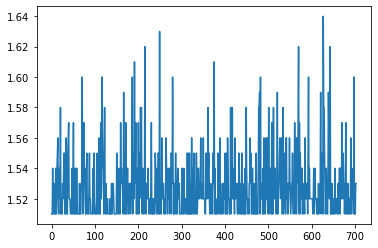

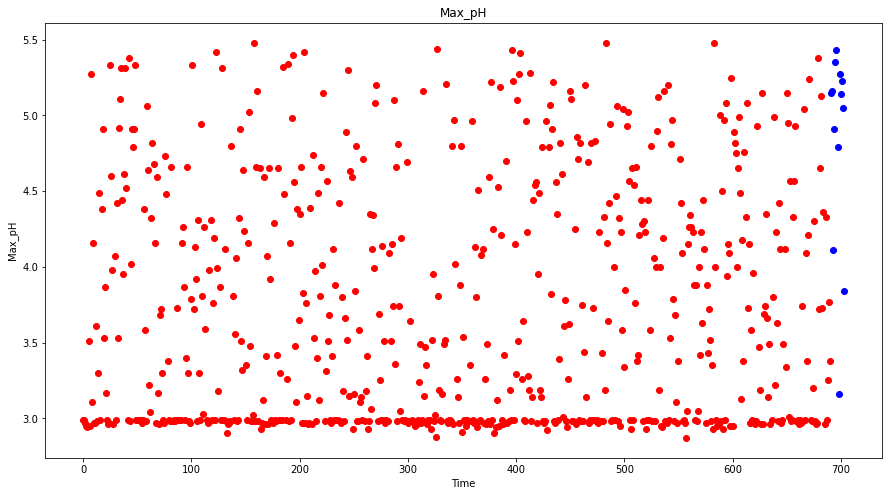

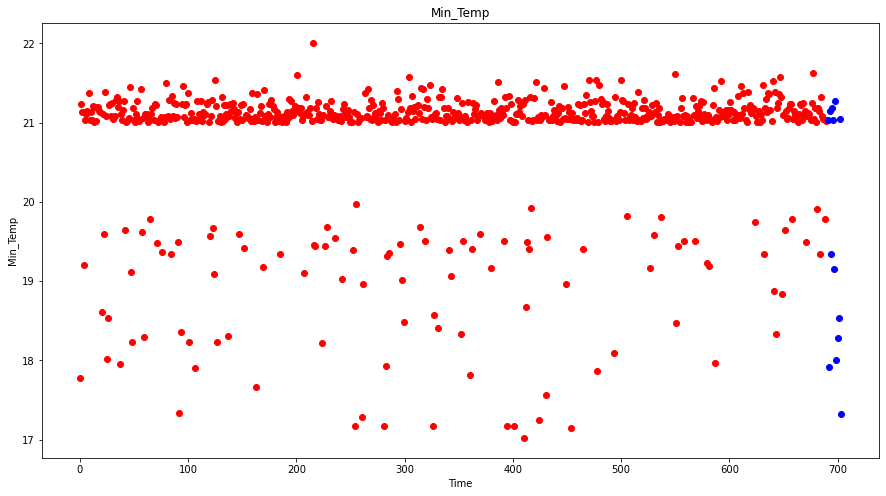

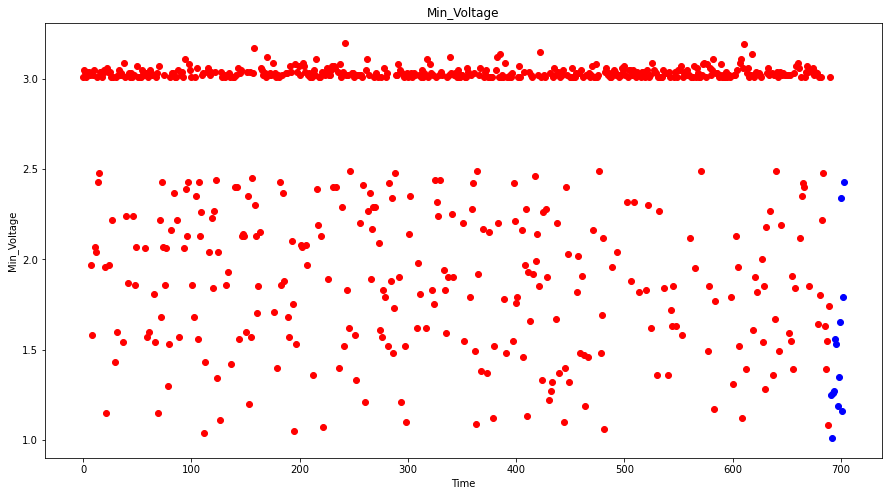

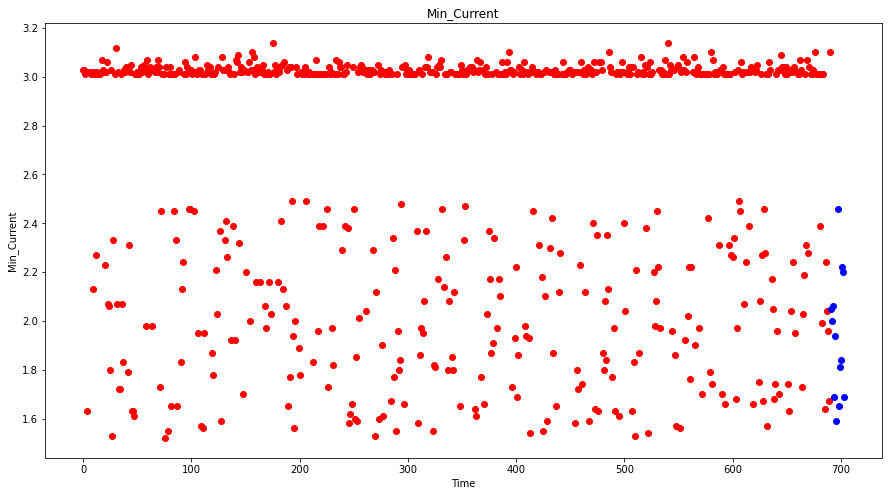

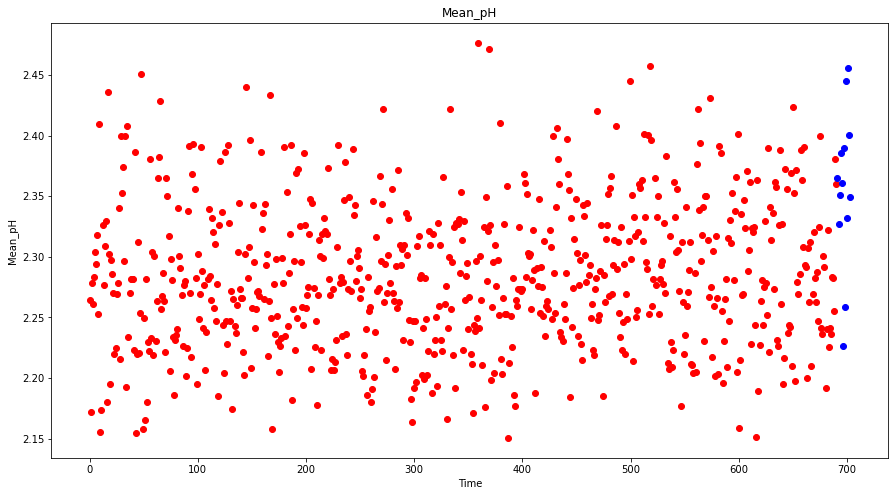

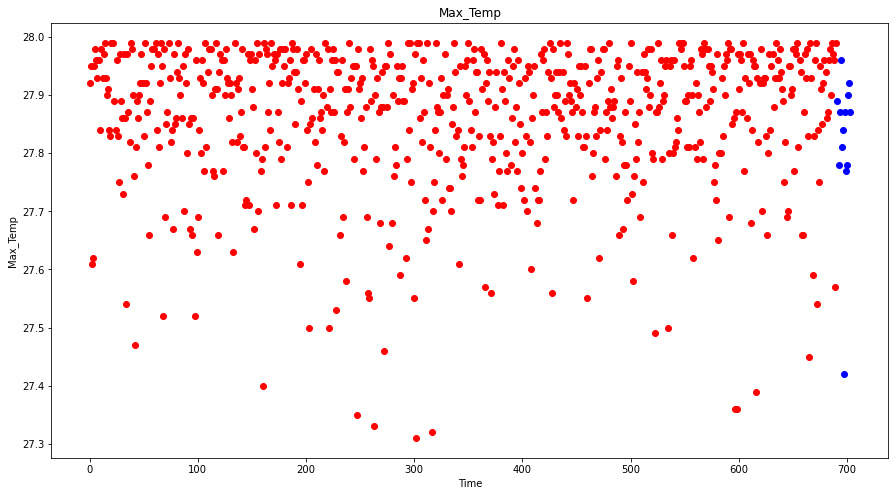

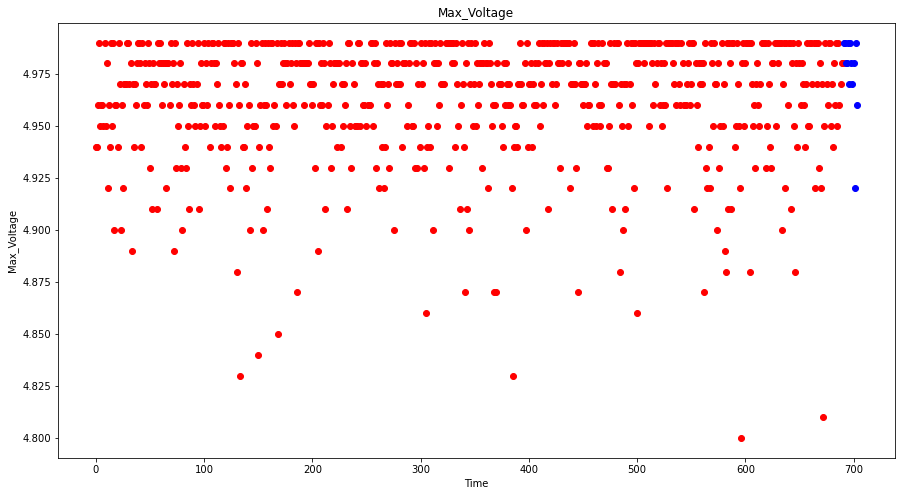

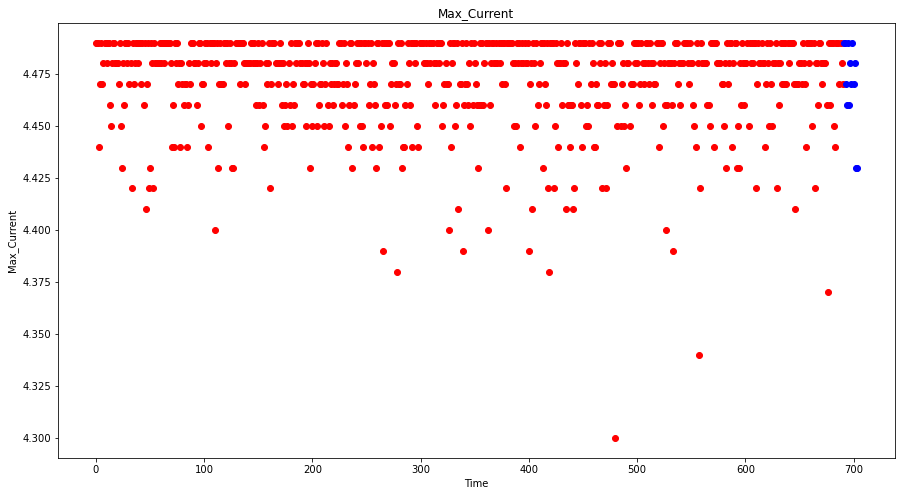

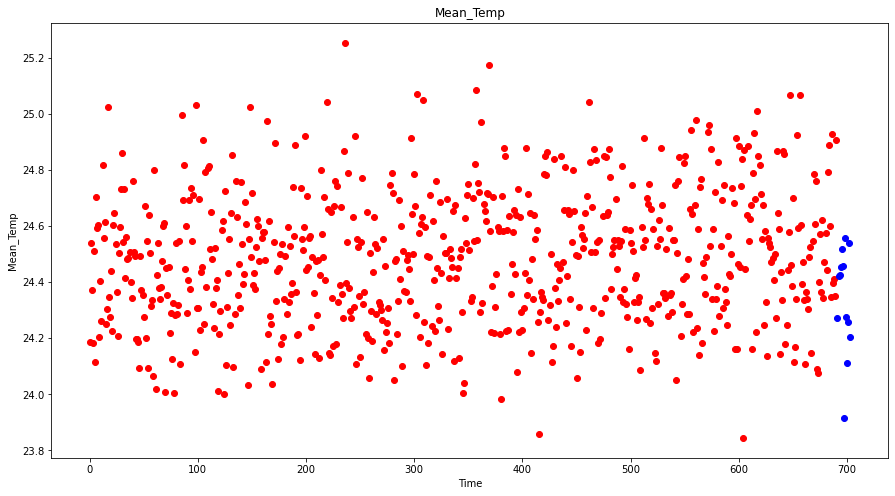

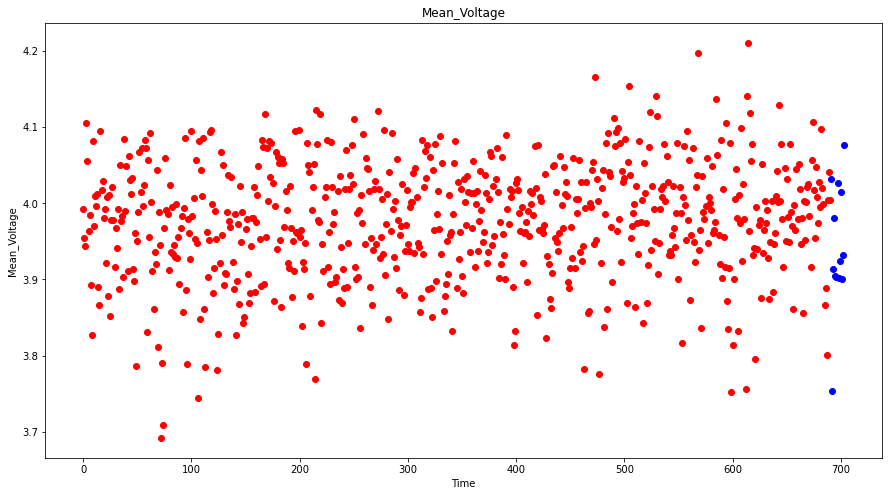

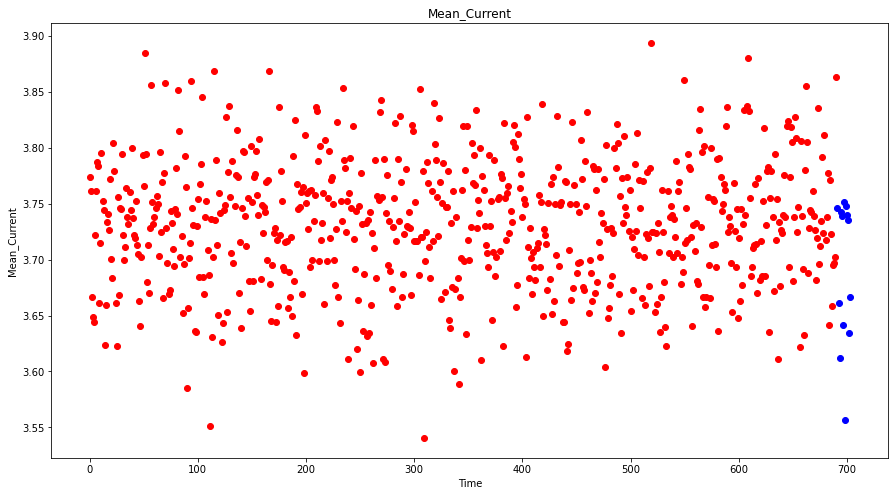

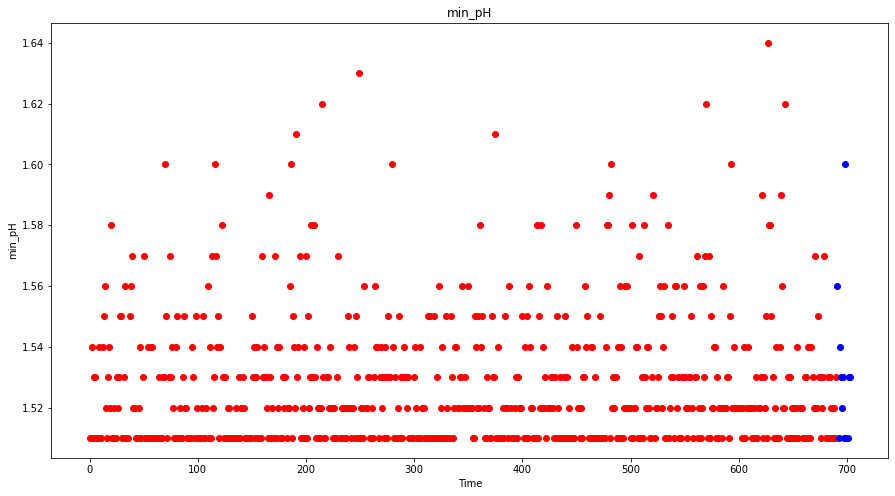

In [33]:
plot_scatter_x(df2)

In [149]:
print(len(df2[df2["error"] == 1]))

13


In [349]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
"""
df = df2[["Max_pH", "Min_Temp", "Min_Voltage", "Min_Current",
                                             "Mean_pH", "Max_Temp", "Max_Voltage", "Max_Current", "Mean_Temp",
                                             "Mean_Voltage", "Mean_Current","min_pH","error"]]
"""
def pca_sensor_data(main_df,df):
    
    df2 = df
    
    #print(df2)
    # 데이터 정규화
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df2)

    # PCA 모델 생성 및 적합
    pca = PCA(n_components=3)
    pca.fit(df_scaled)

    # 주성분 변환
    X_pca = pca.transform(df_scaled)

    # 주성분 변환된 데이터프레임 생성
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

    # 변수의 영향력 계산
    var_exp = pca.explained_variance_ratio_
    components = pca.components_
    k = list(main_df["QC"])

    df_pca["QC"] = k
    plt.figure(figsize = (8,8))
    # 주성분 변환된 데이터프레임과 클러스터 레이블 병합
    #df_pca['Cluster'] = labels
    # 주성분 변환 결과 시각화
    #plt.scatter(df_pca['PC1'], df_pca['PC2'], cmap='viridis',c = k)
    plt.scatter(df_pca.loc[df_pca['QC'] == 0, 'PC1'], df_pca.loc[df_pca['QC'] == 0, 'PC2'], c = 'blue', label='Anomaly')
    plt.scatter(df_pca.loc[df_pca['QC'] == 1, 'PC1'], df_pca.loc[df_pca['QC'] == 1, 'PC2'], c = 'red',alpha = 0.3 ,label='Normal')
    plt.legend()

    #plt.scatter(df_pca['PC1'], df_pca['PC2'], c=k, cmap='viridis')
    #plt.scatter(df_pca['PC1'], df_pca['PC2'], c='red', s=100, label='Anomaly')

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA')

    feature_names = df2.columns
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, components[0, i], components[1, i], color='r', alpha=0.5)
        plt.text(components[0, i]*1.1, components[1, i]*1.1, feature, color='r')

    plt.show()
    return df_pca

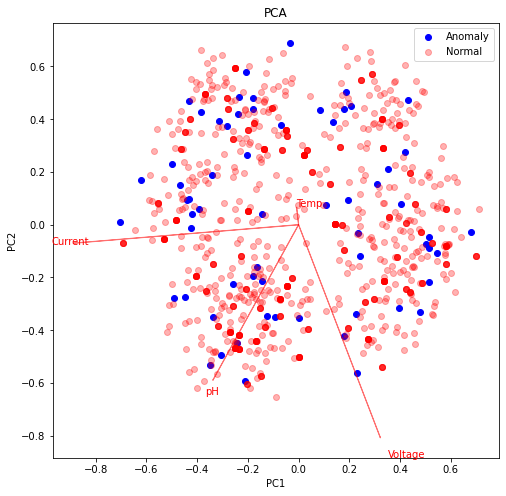

In [527]:
#df = pd.read_csv("allList.csv")
df.head()
df = test_df2
df_pc = df[["pH","Current","Voltage","Temp"]]
#df = df2[["pH"]]
df_pca = pca_sensor_data(df,df_pc)

In [50]:
df.head()

,Time,Lot,pH,Temp,Current,Voltage,DTime,QC
0,27:17.0,1,1.51,23.72,3.03,4.52,2021-09-06,1
1,27:22.0,1,2.84,27.92,3.11,3.43,2021-09-06,1
2,27:27.0,1,1.78,25.44,3.98,4.58,2021-09-06,1
3,27:32.0,1,2.80,21.50,3.45,3.10,2021-09-06,1
4,27:37.0,1,2.63,27.24,4.47,3.26,2021-09-06,1


In [528]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# 클러스터별 데이터 분리
#clusters = df_pca['Cluster'].unique()

# 에러 타입에 따른 색상 매핑

def plot_pca_3D(df_pca):
    error_types = df_pca['QC'].unique()
    colors = sns.color_palette('Set1', len(error_types))

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 에러 타입에 따른 데이터 시각화
    for error_type, color in zip(error_types, colors):
        error_data = df_pca[df_pca['QC'] == error_type]
        ax.scatter(error_data['PC1'], error_data['PC2'], error_data['PC3'], c=[color], alpha = 1, label=error_type)
    ax.view_init(elev = 60, azim= 70)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    #ax.set_xlim(0.4,1.5)
    #ax.set_ylim(-1.5,0.2)
    #ax.set_zlim(0.15,1.5)
    ax.set_title('Clustering Results by Error Type')
    ax.legend()

    plt.show()


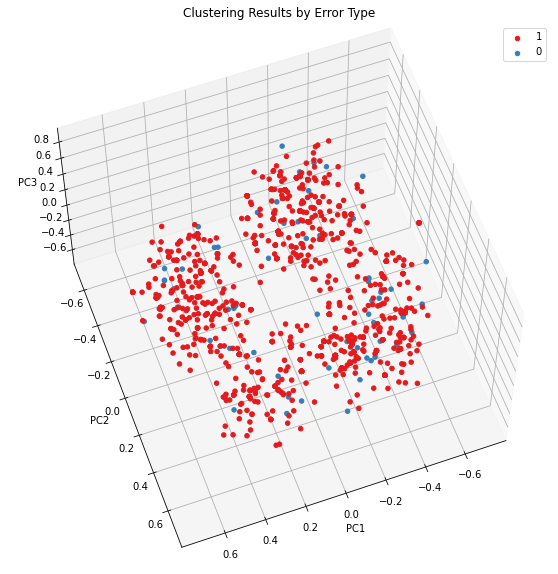

In [529]:
plot_pca_3D(df_pca)

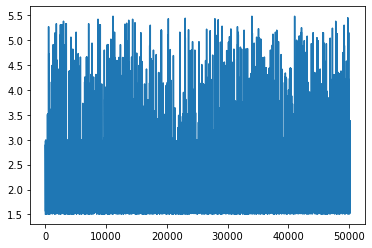

In [143]:
x = [x for x in range(len(df))]
plt.plot(x,df["pH"])

In [479]:
test_df2

,Unnamed: 0,Time,Lot,pH,Temp,Current,Voltage,DTime,error
0,24,29:17.1,1,2.80,17.78,3.66,3.87,2021-09-06,0
1,285,52:26.4,5,2.42,19.20,1.63,3.07,2021-09-06,0
2,523,13:22.4,8,5.27,23.99,3.37,3.22,2021-09-06,0
3,525,13:32.4,8,4.34,24.48,4.00,1.97,2021-09-06,0
4,543,15:02.5,8,4.73,24.60,3.97,4.58,2021-09-06,0
5,600,20:08.6,9,3.11,22.94,4.39,1.58,2021-09-06,0
6,628,22:50.6,10,4.16,23.55,2.13,4.19,2021-09-06,0
7,636,23:30.7,10,4.16,23.55,2.13,4.19,2021-09-06,0
8,669,26:15.8,10,4.16,23.55,2.13,4.19,2021-09-06,0
9,674,26:40.9,10,4.16,23.55,2.13,4.19,2021-09-06,0


In [144]:
data = 'data.csv'
df_list, df_list2 = sensors_of_lots(data)
df2 = lot_data(df_list, df_list2)

<AxesSubplot:>

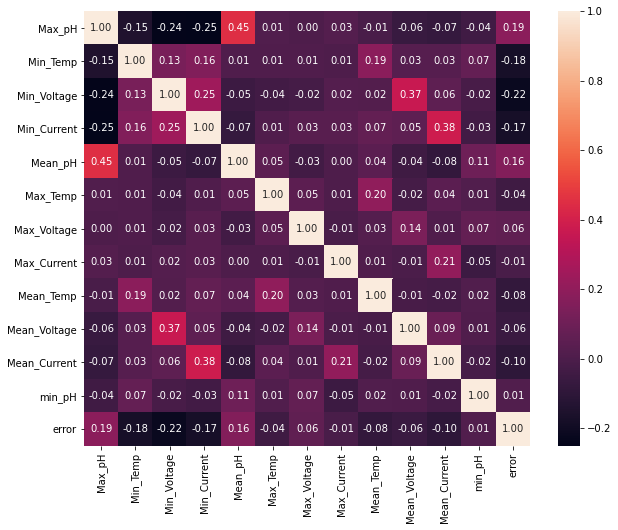

In [146]:
#데이터 상관관계 분석 -> 상관관계 거의 없는듯
dedicated_data1 = df2
correlation = dedicated_data1.corr()
correlation
#상관관계 시각화-> 매우 낮은 상관관계
import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation,annot=True,fmt='.2f')

In [38]:
!pip install graphviz

In [37]:
!pip install --upgrade --force-reinstall numpy



  Using cached numpy-1.19.5-cp36-cp36m-win_amd64.whl (13.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\lib\\site-packages\\numpy-1.19.5.dist-info\\entry_points.txt'
Consider using the `--user` option or check the permissions.



In [2]:
import graphviz

0.020943130708313787
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

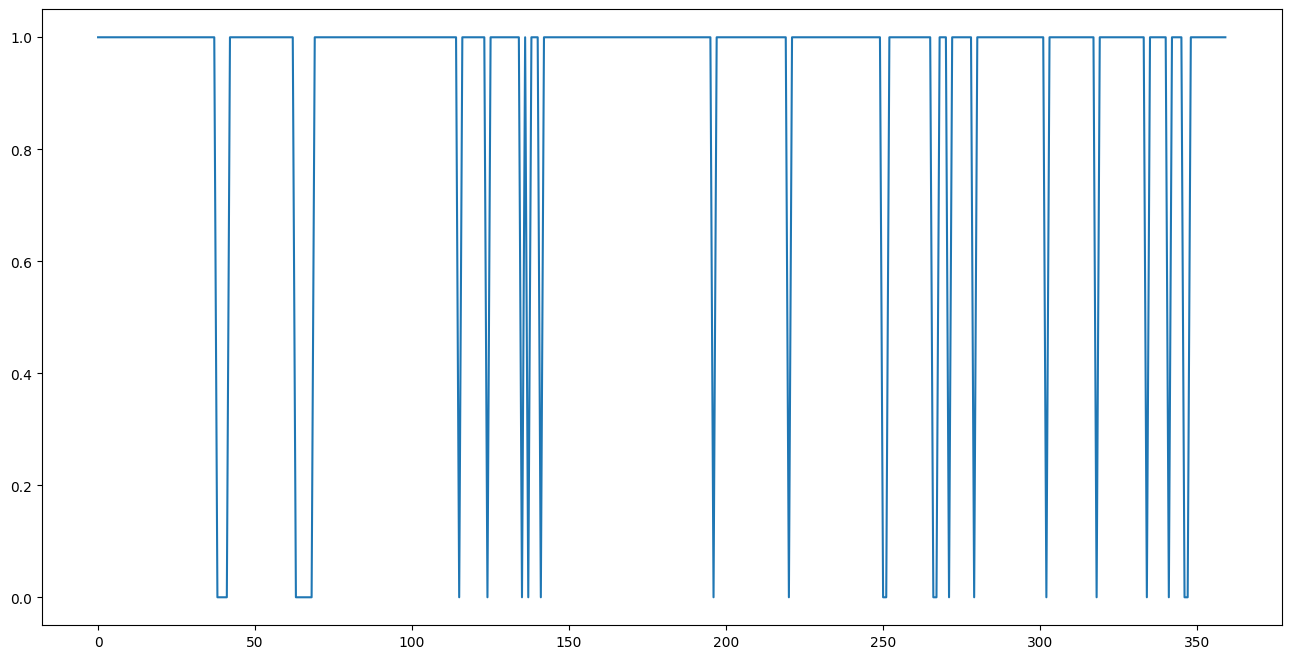

In [3]:
##### from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


#data = 'data.csv'
#df_list, df_list2 = sensors_of_lots(data)
#df2 = lot_data(df_list, df_list2)

#df = df2[["Max_pH", "Min_Temp", "Min_Voltage", "Min_Current",
 #                                            "Mean_pH", "Max_Temp", "Max_Voltage", "Max_Current", "Mean_Temp",
  #                                           "Mean_Voltage", "Mean_Current","min_pH"]]

test_df2 = pd.read_csv("unnormal.csv")

test_df = test_df2[["pH","Current","Temp","Voltage"]]

df3 = pd.read_csv("allList.csv")

df4 = df3[["pH","Current","Temp","Voltage"]]


# 데이터 준비
# X: 독립 변수 (입력 데이터)
# y: 종속 변수 (타겟 데이터)
X = df4[:37000]  # 데이터의 특징을 나타내는 열들로 이루어진 2차원 배열
y = df3["QC"][:37000]  # 데이터의 클래스 레이블 (0 또는 1)

#X = test_df  # 데이터의 특징을 나타내는 열들로 이루어진 2차원 배열
#y = test_df2["QC"]
# 클래스 불균형 비율 계산
class_counts = np.bincount(y)
class_ratio = class_counts[0] / class_counts[1]  # 비정상(1) 클래스에 대한 비율
print(class_ratio)

# 클래스 가중치 설정
class_weights = {0: 1.0, 1: 20}

# 의사결정 나무 모델 학습

# 데이터 분할 (학습 데이터와 테스트 데이터)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 12)

X_train = X
y_train = y

X_test = test_df[700:]
y_test = test_df2["QC"][700:]

# 의사결정나무 모델 생성 및 학습
model = DecisionTreeClassifier(class_weight=class_weights)
model.fit(X_train, y_train)

# Decision Tree 시각화
dot_data = tree.export_graphviz(model, out_file=None,
                               feature_names=X.columns,
                               class_names=["0", "1"],  # 클래스 레이블 이름
                               filled=True, rounded=True,
                               special_characters=True)

graph = graphviz.Source(dot_data)
#graph.render("decision_tree")  # 시각화한 트리를 이미지 파일로 저장 (선택 사항)



# 예측
y_pred = model.predict(X_test)
y_test = y_test.values

fpr, tpr, _ = roc_curve(y_test, y_pred)
# 임계값(threshold) 설정
threshold = 0.5

# 양성 클래스(1)로 분류되는 경우의 확률만 가져옴
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(y_pred_proba)
# 임계값 기준으로 예측 결과 조정
y_pred_adjusted = np.where(y_pred_proba >= threshold, 1, 0)
print(len(y_pred_adjusted))
# 정확도 평가
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test,y_pred_adjusted)
confusion_matrix_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize = (16,8))
x = [i for i in range(len(y_pred_proba))]
plt.plot(x,y_pred_proba)
# 혼동행렬 출력
print(confusion_matrix_df)
print(y_pred)
print(y_test)
y_test

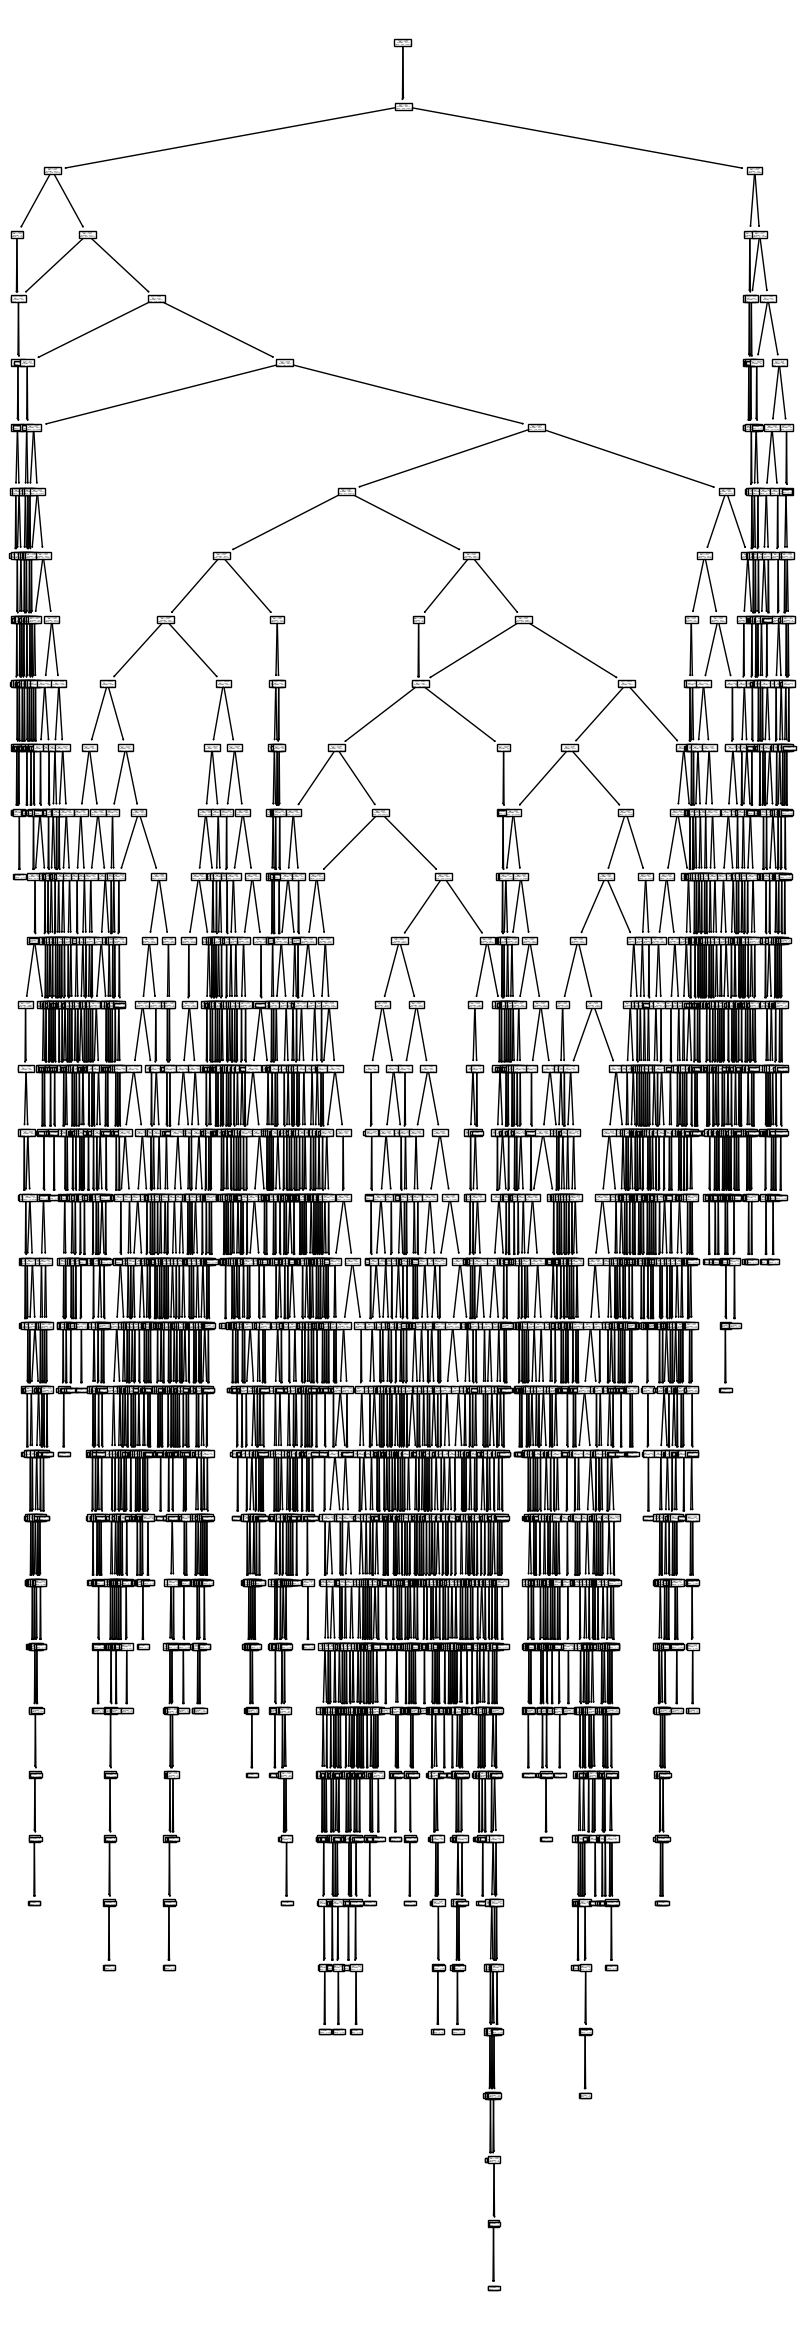

In [4]:
plt.figure(figsize=(10,30)) 
tree.plot_tree(model)
plt.show()

In [5]:
len(test_df2[test_df2["QC"]==0])

62

0.0182328190743338
[0.43147044 0.46602997 0.47543577 ... 0.52947453 0.47209291 0.56277535]
Accuracy: 0.5342338146250583
          Predicted 0  Predicted 1
Actual 0            0          264
Actual 1           24        14741


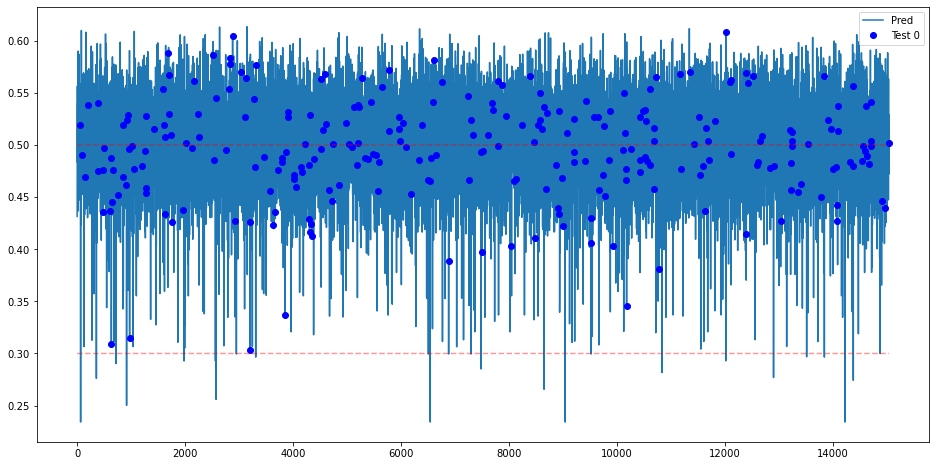

In [505]:
##### from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

#이건 안돌려도 돼 희선아 2023 -06 19 1시


#data = 'data.csv'
#df_list, df_list2 = sensors_of_lots(data)
#df2 = lot_data(df_list, df_list2)

#df = df2[["Max_pH", "Min_Temp", "Min_Voltage", "Min_Current",
 #                                            "Mean_pH", "Max_Temp", "Max_Voltage", "Max_Current", "Mean_Temp",
  #                                           "Mean_Voltage", "Mean_Current","min_pH"]]

test_df2 = pd.read_csv("unnormal.csv")

test_df = test_df2[["pH","Current","Temp","Voltage"]]

df3 = pd.read_csv("allList.csv")

df4 = df3[["pH","Current","Temp","Voltage"]]


# 데이터 준비
# X: 독립 변수 (입력 데이터)
# y: 종속 변수 (타겟 데이터)
X = df4  # 데이터의 특징을 나타내는 열들로 이루어진 2차원 배열
y = df3["QC"]  # 데이터의 클래스 레이블 (0 또는 1)

# 클래스 불균형 비율 계산
class_counts = np.bincount(y)
class_ratio = class_counts[0] / class_counts[1]  # 비정상(1) 클래스에 대한 비율
print(class_ratio)

# 클래스 가중치 설정
class_weights = {0: 1.0, 1: 20}

# 로지스틱 회귀 모델 학습

# 데이터 분할 (학습 데이터와 테스트 데이터)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 12)

X_train = X
y_train = y

X_test = test_df
y_test = test_df2["error"]



model = LogisticRegression(class_weight=class_weights)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_test2 = y_test.values

fpr, tpr, _ = roc_curve(y_test2, y_pred)
# 임계값(threshold) 설정
threshold = 0.3

# 양성 클래스(1)로 분류되는 경우의 확률만 가져옴
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(y_pred_proba)
# 임계값 기준으로 예측 결과 조정
y_pred_adjusted = np.where(y_pred_proba >= threshold, 1, 0)

# 정확도 평가
accuracy = model.score(X_test, y_test2)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test2,y_pred_adjusted)
confusion_matrix_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize = (16,8))
x = [i for i in range(len(y_pred_proba))]
plt.plot(x,y_pred_proba, label = "Pred")
plt.plot(np.where(y_test2 == 0)[0], y_pred_proba[y_test2 == 0], 'bo', label="Test 0")
plt.plot(x, [threshold] * len(y_pred_proba), "--", color="red", alpha=0.4)
plt.plot(x, [0.5] * len(y_pred_proba), "--", color="red", alpha=0.4)
plt.legend()
# 혼동행렬 출력
print(confusion_matrix_df)
#print(y_pred)

0.0182328190743338


KeyError: 'error'

In [486]:
y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [497]:
df

,Unnamed: 0,Time,Lot,pH,Temp,Current,Voltage,DTime,QC,pred
0,24,29:17.1,1,2.80,17.78,3.66,3.87,2021-09-06,1,1
1,285,52:26.4,5,2.42,19.20,1.63,3.07,2021-09-06,1,1
2,523,13:22.4,8,5.27,23.99,3.37,3.22,2021-09-06,1,1
3,525,13:32.4,8,4.34,24.48,4.00,1.97,2021-09-06,1,1
4,543,15:02.5,8,4.73,24.60,3.97,4.58,2021-09-06,1,1
5,600,20:08.6,9,3.11,22.94,4.39,1.58,2021-09-06,1,1
6,628,22:50.6,10,4.16,23.55,2.13,4.19,2021-09-06,1,1
7,636,23:30.7,10,4.16,23.55,2.13,4.19,2021-09-06,1,1
8,669,26:15.8,10,4.16,23.55,2.13,4.19,2021-09-06,1,1
9,674,26:40.9,10,4.16,23.55,2.13,4.19,2021-09-06,1,1


In [37]:
test_df2 = pd.read_csv("unnormal.csv")
df = test_df2[700:]
df["pred"] = y_pred_adjusted
lot_unique = df.groupby(["DTime", "Lot"]).size().reset_index(name='Count') #키 값 생성
#data_unnormal_unique = data_unnormal["DTime"].unique()


df_list = []  # 정상 로트 저장

for i, row in lot_unique.iterrows():
    dt = row["DTime"]
    lot = row["Lot"]
    df_subset = df[(df["DTime"] == dt) & (df["Lot"] == lot)]
    df_list.append(df_subset)

#columns = ["Temp", "Voltage", "pH", "Current"]
#num_columns = len(columns)

# Dtime에 따라 데이터프레임 분할


print(df_list)

<ipython-input-37-244d6df3fb2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"] = y_pred_adjusted


[     Unnamed: 0     Time  Lot    pH   Temp  Current  Voltage       DTime  QC  \
700       32459  16:46.7    9  1.77  25.11      1.9     1.91  2021-10-12   1   

     pred  
700     1  ,      Unnamed: 0     Time  Lot    pH   Temp  Current  Voltage       DTime  QC  \
701       32587  28:07.7   11  2.40  22.61     3.23     2.14  2021-10-12   1   
702       32590  28:22.7   11  2.02  21.11     3.18     1.47  2021-10-12   1   

     pred  
701     1  
702     1  ,      Unnamed: 0     Time  Lot    pH   Temp  Current  Voltage       DTime  QC  \
703       32678  36:03.4   12  2.52  21.04     3.24     1.19  2021-10-12   1   
704       32695  37:28.4   12  5.20  24.46     2.12     4.00  2021-10-12   1   

     pred  
703     1  
704     1  ,      Unnamed: 0     Time  Lot    pH   Temp  Current  Voltage       DTime  QC  \
705       32832  49:35.3   14  4.69  25.79     3.67     1.46  2021-10-12   1   

     pred  
705     1  ,      Unnamed: 0     Time  Lot    pH   Temp  Current  Voltage       DTim

In [38]:
def lot_data2(df_list):
    # 새로운 데이터프레임을 저장할 리스트
    new_data = []
    # 각 데이터프레임 별로 최대, 최소, 평균 값을 구하고 새로운 데이터프레임에 추가
    for df in df_list:
        error = df["QC"].max()
        number_of_error = len(df)
        #print(number_of_error)
        number_of_true = 0
        number_of_false = 0
        for index, row in df.iterrows():
            if row["QC"] == row["pred"]: 
                number_of_true +=1
            else:
                number_of_false +=1
        Lot = df["Lot"].iloc[0]
        DTime = df["DTime"].iloc[0]
        new_data.append([Lot, DTime, error, number_of_error, number_of_true, number_of_false])

    # 새로운 데이터프레임 생성
    new_df = pd.DataFrame(new_data, columns=["Lot", "DTime","error_type","number_of_error","number_of_ture","number_of_false"])
    new_df.set_index(["Lot", "DTime"], inplace=True)

    # 새로운 데이터프레임 출력
    return new_df

In [39]:
a = lot_data2(df_list)
a[(a["error_type"]==1) & (a["number_of_false"]>=1)]

,,error_type,number_of_error,number_of_ture,number_of_false
Lot,DTime,,,,
14,2021-10-15,1,2,1,1
2,2021-10-18,1,1,0,1
9,2021-10-18,1,1,0,1
1,2021-10-20,1,3,2,1
17,2021-10-20,1,3,2,1
18,2021-10-20,1,3,2,1
5,2021-10-21,1,2,1,1
4,2021-10-22,1,2,0,2
5,2021-10-25,1,1,0,1
